# Human's comments

This is AI-generated code after a few iterations on this problem. It was an interesting process - how the AI started out using a list, and I had to instruct it to migrate first to numpy arrays and later to matrix operations, while not exactly understanding the intricacies behind the CSR representation. So I ended up getting the assistant to create this step-by-step explanation (including for the CSR indexation) so I could understand and debug its solution. 

## The Idea
What I wanted done was the following: 

Given a CSR matrix of user x item interactions (a common representation in recommendation problems), build a randomized holdout set. That is, for each user, remove a share of its interacted items (replace with 0, or rather, remove from the CSR structure) and add them to a `y_true` variable. This way the interactions can be safely sent to the model while the holdout can be used as validation. 

The complementary problem also applies - removing interactions when looking at items instead of users. 

## Now for the AI 

# Holdout creation: step-by-step with visualizations

This notebook walks through how **holdout_per_user** works (same ideas apply to **holdout_per_item**). We use a tiny user×item matrix so every array can be inspected and plotted.

**Goal:** For each user (row), randomly split their interactions into:
- **Viewable** — used to fit/recompute the model and to filter "already seen" items.
- **Held-out** — used only as ground truth (y_true) for evaluation.

We use **CSR (Compressed Sparse Row)** layout: row `i`'s nonzeros are in `data[indptr[i]:indptr[i+1]]` with column indices `indices[indptr[i]:indptr[i+1]]`.

In [1]:
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# Small toy matrix: 4 users × 5 items (rows = users, cols = items)
# Nonzeros: user0→(0,1,2), user1→(1,2), user2→(0,2,3), user3→(2,4)
row = np.array([0, 0, 0, 1, 1, 2, 2, 2, 3, 3])
col = np.array([0, 1, 2, 1, 2, 0, 2, 3, 2, 4])
data = np.array([1., 2., 3., 1., 1., 1., 1., 1., 1., 1.])
user_items = csr_matrix((data, (row, col)), shape=(4, 5))

n_users, n_items = user_items.shape
print("Shape:", user_items.shape, "  nnz:", user_items.nnz)
pd.DataFrame(user_items.toarray(), index=[f"user{i}" for i in range(n_users)], columns=[f"item{j}" for j in range(n_items)])

Shape: (4, 5)   nnz: 10


,item0,item1,item2,item3,item4
user0,1.0,2.0,3.0,0.0,0.0
user1,0.0,1.0,1.0,0.0,0.0
user2,1.0,0.0,1.0,1.0,0.0
user3,0.0,0.0,1.0,0.0,1.0


## Step 0: CSR layout (indptr, indices, data)

The matrix is stored as three arrays. **indptr** has length `n_users + 1`: row `i`'s nonzeros are at positions `indptr[i]` to `indptr[i+1] - 1` in `indices` and `data`.

In [2]:
indptr = user_items.indptr
indices = user_items.indices
data = user_items.data
total_nnz = indices.size

print("indptr (length n_users+1):", indptr)
print("indices (column for each nonzero):", indices)
print("data (value for each nonzero):", data)

# Table: one row per nonzero, showing (row, col, value) and which indptr range it belongs to
rows_expanded = np.repeat(np.arange(n_users), np.diff(indptr))
tbl = pd.DataFrame({
    "position": np.arange(total_nnz),
    "row (user)": rows_expanded,
    "col (item)": indices,
    "value": data,
})
tbl["row range"] = [f"indptr[{r}]:{indptr[r+1]}" for r in rows_expanded]
tbl

indptr (length n_users+1): [ 0  3  5  8 10]
indices (column for each nonzero): [0 1 2 1 2 0 2 3 2 4]
data (value for each nonzero): [1. 2. 3. 1. 1. 1. 1. 1. 1. 1.]


,position,row (user),col (item),value,row range
0,0,0,0,1.0,indptr[0]:3
1,1,0,1,2.0,indptr[0]:3
2,2,0,2,3.0,indptr[0]:3
3,3,1,1,1.0,indptr[1]:5
4,4,1,2,1.0,indptr[1]:5
5,5,2,0,1.0,indptr[2]:8
6,6,2,2,1.0,indptr[2]:8
7,7,2,3,1.0,indptr[2]:8
8,8,3,2,1.0,indptr[3]:10
9,9,3,4,1.0,indptr[3]:10


## Step 1: How many to hold out per user? (`_holdout_counts`)

- **nnz_per_row** = number of nonzeros in each row (`np.diff(indptr)`).
- For each row we compute **n_held** and **n_viewable** so that: at least 1 viewable (to compute user factor), and if the row has 2+ entries, at least 1 held-out (to evaluate). Formula: `n_held = clip(round(holdout_ratio * nnz), 1, nnz-1)` for rows with nnz > 1.

In [12]:
print(indptr)
print(np.diff(indptr))

[ 0  3  5  8 10]
[3 2 3 2]


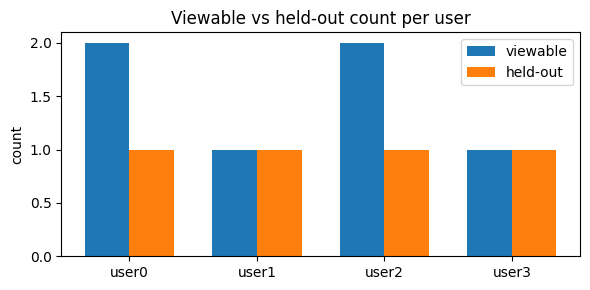

In [3]:
from src.split import _holdout_counts

holdout_ratio = 0.33
nnz_per_row = np.diff(indptr)
n_held, n_viewable = _holdout_counts(nnz_per_row, holdout_ratio)

counts = pd.DataFrame({
    "user": np.arange(n_users),
    "nnz": nnz_per_row,
    "n_held": n_held,
    "n_viewable": n_viewable,
})
counts

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
x = np.arange(n_users)
w = 0.35
ax.bar(x - w/2, n_viewable, w, label="viewable", color="C0")
ax.bar(x + w/2, n_held, w, label="held-out", color="C1")
ax.set_xticks(x)
ax.set_xticklabels([f"user{i}" for i in range(n_users)])
ax.set_ylabel("count")
ax.legend()
ax.set_title("Viewable vs held-out count per user")
plt.tight_layout()
plt.show()

## Step 2: Shuffle within each row (`_shuffle_within_entities`)

We need to **randomly** choose which entries are viewable vs held-out (not always the first few). We assign a random key to each nonzero and sort by `(row_id, random_key)`. That keeps entries grouped by row but in random order within each row.

In [4]:
from src.split import _shuffle_within_entities

rng = np.random.default_rng(42)
row_id = np.repeat(np.arange(n_users, dtype=np.intp), nnz_per_row)
random_key = rng.random(total_nnz)
sort_idx = np.lexsort((random_key, row_id))

indices_sorted = indices[sort_idx]
data_sorted = data[sort_idx]

# Before/after: each row shows one nonzero; after sort, order within each user is random
shuffle_tbl = pd.DataFrame({
    "position (original)": np.arange(total_nnz),
    "user": row_id,
    "item (original order)": indices,
    "item (after shuffle)": indices_sorted,
    "random_key": random_key[sort_idx],  # keys in sorted order
})
shuffle_tbl

,position (original),user,item (original order),item (after shuffle),random_key
0,0,0,0,1,0.438878
1,1,0,1,0,0.773956
2,2,0,2,2,0.858598
3,3,1,1,2,0.094177
4,4,1,2,1,0.697368
5,5,2,0,2,0.761140
6,6,2,2,3,0.786064
7,7,2,3,0,0.975622
8,8,3,2,2,0.128114
9,9,3,4,4,0.450386


In [5]:
# Visual: in sorted order, each user's entries are contiguous; order within user is random.
# "Viewable" = first n_viewable entries per user in this table; "held-out" = the rest.
print("In sorted order (by user, then random): first n_viewable per user → viewable; rest → held-out\n")
for i in range(n_users):
    start, end = indptr[i], indptr[i + 1]
    # positions in SORTED array that belong to this user (same as start:end in sorted)
    user_positions = np.where(row_id[sort_idx] == i)[0]
    n_v = n_viewable[i]
    viewable_items = indices_sorted[user_positions[:n_v]]
    held_items = indices_sorted[user_positions[n_v:]]
    print(f"  user{i}: viewable items = {viewable_items.tolist()},  held-out items = {held_items.tolist()}")

In sorted order (by user, then random): first n_viewable per user → viewable; rest → held-out

  user0: viewable items = [1, 0],  held-out items = [2]
  user1: viewable items = [2],  held-out items = [1]
  user2: viewable items = [2, 3],  held-out items = [0]
  user3: viewable items = [2],  held-out items = [4]


## Step 3: Viewable mask (`_viewable_mask`)

In the **sorted** order, each user's entries are contiguous. "Position within user" = 0, 1, 2, ... for that user's block. We mark as viewable every entry where `position_in_row < n_viewable[user]`.

In [14]:
from src.split import _viewable_mask

viewable_mask = _viewable_mask(total_nnz, indptr, nnz_per_row, n_viewable)
viewable_mask

array([ True,  True, False,  True, False,  True,  True, False,  True,
       False])

In [ ]:

position_in_row = np.arange(total_nnz, dtype=np.intp) - np.repeat(indptr[:-1], nnz_per_row)

mask_tbl = pd.DataFrame({
    "position": np.arange(total_nnz),
    "user": row_id[sort_idx],
    "item": indices_sorted,
    "position_in_row": position_in_row,
    "n_viewable[user]": np.repeat(n_viewable, nnz_per_row),
    "viewable?": viewable_mask,
})
mask_tbl

,position,user,item,position_in_row,n_viewable[user],viewable?
0,0,0,1,0,2,True
1,1,0,0,1,2,True
2,2,0,2,2,2,False
3,3,1,2,0,1,True
4,4,1,1,1,1,False
5,5,2,2,0,2,True
6,6,2,3,1,2,True
7,7,2,0,2,2,False
8,8,3,2,0,1,True
9,9,3,4,1,1,False


## Step 4: Build the viewable matrix and y_true

- **Viewable matrix**: same shape as original; only the entries where `viewable_mask` is True are kept (others become 0).
- **y_true**: list of arrays; `y_true[i]` = column indices (items) held out for user `i`.

In [17]:
viewable_indptr = np.empty(n_users + 1, dtype=np.intp)
viewable_indptr[0] = 0

np.cumsum(n_viewable, out=viewable_indptr[1:])
print(viewable_indptr)
print(data_sorted[viewable_mask])
print(indices_sorted[viewable_mask])

[0 2 3 5 6]
[2. 1. 1. 1. 1. 1.]
[1 0 2 2 3 2]


In [ ]:
from src.split import _held_out_splits

viewable = csr_matrix(
    (data_sorted[viewable_mask], indices_sorted[viewable_mask], viewable_indptr),
    shape=(n_users, n_items),
    dtype=user_items.dtype,
)
y_true_held_out = _held_out_splits(indices_sorted, viewable_mask, n_held, n_users, indices.dtype)

print("y_true (held-out item indices per user):")
for i in range(n_users):
    print(f"  user{i}: {y_true_held_out[i].tolist()}")

y_true (held-out item indices per user):
  user0: [2]
  user1: [1]
  user2: [0]
  user3: [4]


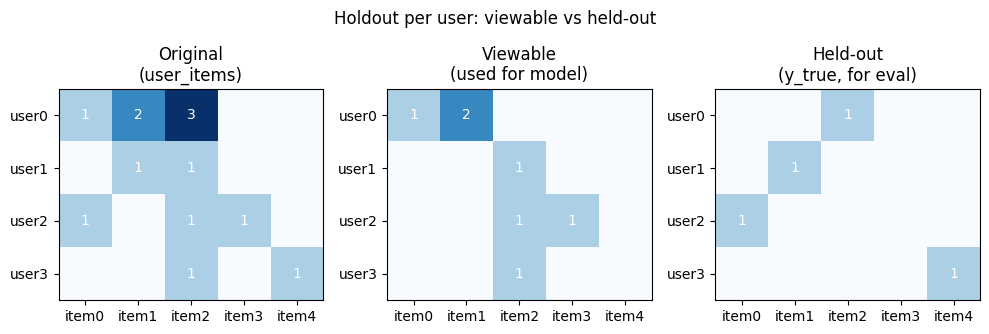

In [8]:
# Side-by-side: original matrix vs viewable matrix (held-out entries become 0)
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))
A = user_items.toarray()
V = viewable.toarray()
# Held-out mask: 1 where we held out, 0 elsewhere (for display)
H = np.zeros_like(A)
for i in range(n_users):
    H[i, y_true_held_out[i]] = 1

for ax, mat, title in zip(
    axes,
    [A, V, H],
    ["Original\n(user_items)", "Viewable\n(used for model)", "Held-out\n(y_true, for eval)"],
):
    im = ax.imshow(mat, cmap="Blues", vmin=0, vmax=max(1, A.max()))
    ax.set_xticks(np.arange(n_items))
    ax.set_xticklabels([f"item{j}" for j in range(n_items)])
    ax.set_yticks(np.arange(n_users))
    ax.set_yticklabels([f"user{i}" for i in range(n_users)])
    for i in range(n_users):
        for j in range(n_items):
            val = mat[i, j]
            if val != 0:
                ax.text(j, i, f"{int(val)}", ha="center", va="center", color="white" if val > 0.5 else "black")
    ax.set_title(title)
plt.suptitle("Holdout per user: viewable vs held-out")
plt.tight_layout()
plt.show()

## Step 5: Verify with `holdout_per_user`

Calling the real function with the same `random_state=42` should reproduce the same viewable matrix and y_true.

In [9]:
from src.split import holdout_per_user

viewable_ref, y_true_ref = holdout_per_user(user_items, holdout_ratio=holdout_ratio, random_state=42)
print("Viewable matrices equal:", np.allclose(viewable.toarray(), viewable_ref.toarray()))
print("y_true equal:", all(np.array_equal(a, b) for a, b in zip(y_true_held_out, y_true_ref)))

Viewable matrices equal: True
y_true equal: True


---

# Holdout per item (same idea, along columns)

**holdout_per_item** does the same pipeline but for **columns** (items): we use the matrix in **CSC** form so that "entity" = column. Then:
- **Viewable** = subset of nonzeros per column (item) kept for recomputing item factors.
- **y_true[j]** = row indices (users) held out for item j — used for "inverse" evaluation (rank users per artist).

Held-out user indices per item (for item_inverse evaluation):
  item0: [0]
  item1: [0]
  item2: [1]
  item3: []
  item4: []


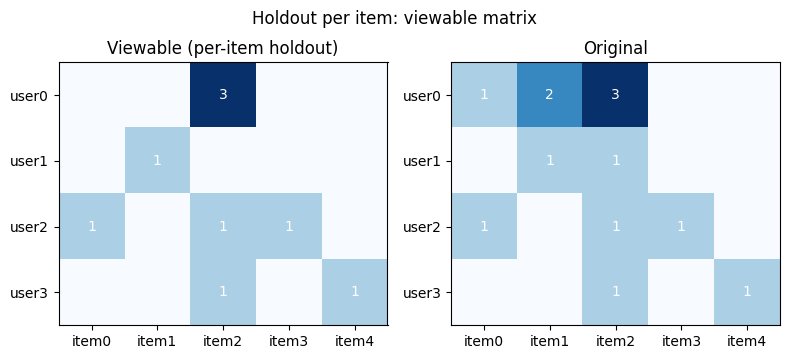

In [10]:
from src.split import holdout_per_item

viewable_item, y_true_item = holdout_per_item(user_items, holdout_ratio=0.33, random_state=42)
# y_true_item[j] = user indices held out for item j
print("Held-out user indices per item (for item_inverse evaluation):")
for j in range(n_items):
    print(f"  item{j}: {y_true_item[j].tolist()}")

fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
for ax, mat, title in zip(
    axes,
    [viewable_item.toarray(), user_items.toarray()],
    ["Viewable (per-item holdout)", "Original"],
):
    im = ax.imshow(mat, cmap="Blues", vmin=0, vmax=user_items.toarray().max())
    ax.set_xticks(np.arange(n_items))
    ax.set_xticklabels([f"item{j}" for j in range(n_items)])
    ax.set_yticks(np.arange(n_users))
    ax.set_yticklabels([f"user{i}" for i in range(n_users)])
    for i in range(n_users):
        for j in range(n_items):
            val = mat[i, j]
            if val != 0:
                ax.text(j, i, f"{int(val)}", ha="center", va="center", color="white" if val > 0.5 else "black")
    ax.set_title(title)
plt.suptitle("Holdout per item: viewable matrix")
plt.tight_layout()
plt.show()